In [52]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, List, Optional
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import jax
import jax.numpy as jnp
from jax import random

from rwMH import rwMH_run    
from HMC  import hmc_run 

Array = jnp.ndarray
LogProbFn = Callable[[Array], Array]


In [53]:
def standard_normal_log_prob(x: Array) -> Array:
    x = jnp.asarray(x) 
    D = x.shape[-1]
    two_pi = jnp.array(2.0 * jnp.pi, dtype=x.dtype)
    half   = jnp.array(0.5, dtype=x.dtype)   
    return -half * (jnp.sum(x**2, axis=-1) + D * jnp.log(two_pi))


def make_init(n_chains: int, d: int) -> Array:
    return jnp.zeros((n_chains, d), dtype=jnp.float32)

def to_inferencedata(samples_tcd: np.ndarray) -> az.InferenceData:
    draws, chains, dims = samples_tcd.shape
    arr = np.transpose(samples_tcd, (1, 0, 2))  # (chain, draw, dim)
    data = {"x": arr}
    idata = az.from_dict(posterior=data, coords={"dim": np.arange(dims)}, dims={"x": ["dim"]})
    return idata


In [54]:
def compute_arviz_summary(samples_tcd: np.ndarray) -> pd.DataFrame:
    idata = to_inferencedata(samples_tcd)
    summ = az.summary(idata, var_names=["x"], round_to=None)
    keep = ["mean", "sd", "mcse_mean", "r_hat", "ess_bulk"]
    cols = [c for c in keep if c in summ.columns]
    return summ[cols]

def _acf_fft(x: np.ndarray, max_lag: int = 100) -> np.ndarray:
    x = x.astype(float)
    x = x - x.mean()
    n = len(x)
    nfft = 1 << (2*n - 1).bit_length()
    fx = np.fft.rfft(x, n=nfft)
    acf_full = np.fft.irfft(fx * np.conj(fx), n=nfft)[:n]
    acf_full /= max(acf_full[0], 1e-12)
    return acf_full[:max_lag+1]

def plot_traces(samples_tcd: np.ndarray, dims: int = 3, chain: int = 0, title: Optional[str] = None):
    T, C, D = samples_tcd.shape
    k = min(dims, D)
    xs = samples_tcd[:, chain, :k]
    fig, axes = plt.subplots(k, 1, figsize=(10, 1.8*k), sharex=True)
    axes = np.atleast_1d(axes)
    for i in range(k):
        axes[i].plot(xs[:, i], linewidth=0.9)
        axes[i].set_ylabel(f"x[{i}]")
    axes[-1].set_xlabel("iteration")
    if title:
        fig.suptitle(title)
    plt.show()

def plot_acf(samples_tcd: np.ndarray, max_lag: int = 100, dims: int = 3, chain: int = 0, title: Optional[str] = None):
    T, C, D = samples_tcd.shape
    k = min(dims, D)
    xs = samples_tcd[:, chain, :k]
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i in range(k):
        acf = _acf_fft(xs[:, i], max_lag=max_lag)
        ax.plot(np.arange(len(acf)), acf, label=f"x[{i}]")
    ax.set_xlabel("lag")
    ax.set_ylabel("ACF")
    if title:
        ax.set_title(title)
    ax.legend()
    plt.show()

def plot_marginals_vs_true(samples_tcd: np.ndarray):
    T, C, D = samples_tcd.shape
    if D != 2:
        return
    flat = samples_tcd.reshape(T*C, D)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    x = flat[:, 0]
    xs = np.linspace(x.min(), x.max(), 300)
    ax.hist(x, bins=60, density=True, alpha=0.5, label="samples")
    pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * xs**2)
    ax.plot(xs, pdf, label="N(0,1)")
    ax.set_title("Marginal x[0] vs N(0,1)")
    ax.legend()
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(flat[:, 0], flat[:, 1], s=5, alpha=0.2)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Samples (x0, x1)")
    plt.show()


In [55]:
def unpack_run_output(out, num_samples: int) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray], object]:
    """
    Accepts either:
      - (samples, state)
      - (samples, lps, accept_rate, state)
    Returns: (samples_tcd, lps_t_c or None, accept_rate_c or None, state)
      samples_tcd is (T, C, D) as numpy array.
    """
    if isinstance(out, tuple) and len(out) == 2:
        samples, state = out
        samples = np.array(samples)
        lps = None
        accept_rate = None
    elif isinstance(out, tuple) and len(out) >= 4:
        samples, lps, accept_rate, state = out[0], out[1], out[2], out[3]
        samples = np.array(samples)
        lps = np.array(lps)
        accept_rate = np.array(accept_rate)
    else:
        raise ValueError("Unexpected run() return signature. Expected (samples,state) or (samples,lps,accept_rate,state).")
    # compute accept_rate from state if not given
    if accept_rate is None and hasattr(state, "accept_count"):
        C = state.accept_count.shape[0]
        accept_rate = np.asarray(state.accept_count, dtype=float) / float(num_samples)
    return samples, lps, accept_rate, state


In [56]:
def summarize_run(samples_tcd: np.ndarray, accept_rate_c: np.ndarray, seconds: float) -> Dict:
    summ = compute_arviz_summary(samples_tcd)
    rhat = summ["r_hat"].to_numpy()
    ess = summ["ess_bulk"].to_numpy()
    mcse = summ["mcse_mean"].to_numpy()
    ess_sec = ess / max(seconds, 1e-9)
    return dict(
        accept_rate=accept_rate_c,
        rhat=rhat,
        ess=ess,
        ess_sec=ess_sec,
        mcse=mcse,
        seconds=seconds,
        samples=samples_tcd,
    )


In [117]:
def run_grid_for_d(
    d: int,
    key: Array,
    n_chains: int = 4,
    burn_in_rwm: int = 1000,
    num_samples_rwm: int = 4000,
    burn_in_hmc: int = 1000,
    num_samples_hmc: int = 4000,
    rwm_scales = (0.5, 0.75, 1.0),
    hmc_eps    = (0.1, 0.13, 0.15, 0.17, 0.2, 0.25, 0.3),
    hmc_L      = (10, 15, 20, 25, 30, 35, 40),
) -> Tuple[pd.DataFrame, Optional[Dict], Optional[Dict]]:
    """Run grid searches for a fixed dimension and summarize."""
    rows: List[Dict] = []
    init = make_init(n_chains, d)

    # RWMH grid
    for scale in rwm_scales:
        key, sub = random.split(key)
        t0 = time.perf_counter()
        out = rwMH_run(sub, standard_normal_log_prob, init, num_samples_rwm, float(scale), burn_in=burn_in_rwm)
        seconds = time.perf_counter() - t0
        samples, lps, accept_rate, state = unpack_run_output(out, num_samples_rwm)
        diag = summarize_run(samples, accept_rate, seconds)
        rows.append(dict(
            method="RWMH",
            d=d,
            hyper=f"scale={scale}",
            accept_mean=float(diag["accept_rate"].mean()),
            rhat_max=float(diag["rhat"].max()),
            ess_mean=float(diag["ess"].mean()),
            ess_sec_mean=float(diag["ess_sec"].mean()),
            mcse_mean_max=float(diag["mcse"].max()),
            aux=dict(scale=float(scale)),
            diag=diag,
        ))

    # HMC grid
    for eps in hmc_eps:
        for L in hmc_L:
            key, sub = random.split(key)
            t0 = time.perf_counter()
            out = hmc_run(sub, standard_normal_log_prob, init, float(eps), int(L), num_samples_hmc, burn_in=burn_in_hmc)
            seconds = time.perf_counter() - t0
            samples, lps, accept_rate, state = unpack_run_output(out, num_samples_hmc)
            diag = summarize_run(samples, accept_rate, seconds)
            rows.append(dict(
                method="HMC",
                d=d,
                hyper=f"eps={eps},L={L}",
                accept_mean=float(diag["accept_rate"].mean()),
                rhat_max=float(diag["rhat"].max()),
                ess_mean=float(diag["ess"].mean()),
                ess_sec_mean=float(diag["ess_sec"].mean()),
                mcse_mean_max=float(diag["mcse"].max()),
                aux=dict(eps=float(eps), L=int(L)),
                diag=diag,
            ))

    df = pd.DataFrame([
        {
            "method": r["method"],
            "d": r["d"],
            "hyper": r["hyper"],
            "accept_mean": r["accept_mean"],
            "rhat_max": r["rhat_max"],
            "ess_mean": r["ess_mean"],
            "ess_sec_mean": r["ess_sec_mean"],
            "mcse_mean_max": r["mcse_mean_max"],
        }
        for r in rows
    ])

    def pick_best(method: str) -> Optional[Dict]:
        cand = [r for r in rows if r["method"] == method and r["rhat_max"] <= 1.01]
        if not cand:
            return None
        target_acc = 0.3 if method == "RWMH" else 0.7
        def score(r):
            return (r["ess_sec_mean"], -abs(r["accept_mean"] - target_acc), -r["mcse_mean_max"])
        return max(cand, key=score)

    best_rwm = pick_best("RWMH")
    best_hmc = pick_best("HMC")
    return df, best_rwm, best_hmc


In [83]:
import importlib, rwMH, HMC
importlib.reload(rwMH)
importlib.reload(HMC)

from rwMH import rwMH_run, standard_normal_log_prob 
from HMC import hmc_run, standard_normal_log_prob

In [118]:
key = random.PRNGKey(0)

df2, best_rwm_2, best_hmc_2 = run_grid_for_d(2, key, n_chains=4, burn_in_rwm=1000, num_samples_rwm=4000,
                                              burn_in_hmc=1000, num_samples_hmc=4000)
key = random.PRNGKey(1)
df10, best_rwm_10, best_hmc_10 = run_grid_for_d(10, key, n_chains=4, burn_in_rwm=1000, num_samples_rwm=4000,
                                                 burn_in_hmc=1000, num_samples_hmc=4000)

display(df2.style.format(precision=4).set_caption("Summary (d=2)"))
display(df10.style.format(precision=4).set_caption("Summary (d=10)"))

print("Best RWMH (d=2):", best_rwm_2["hyper"] if best_rwm_2 else "none")
print("Best HMC  (d=2):", best_hmc_2["hyper"] if best_hmc_2 else "none")
print("Best RWMH (d=10):", best_rwm_10["hyper"] if best_rwm_10 else "none")
print("Best HMC  (d=10):", best_hmc_10["hyper"] if best_hmc_10 else "none")


,method,d,hyper,accept_mean,rhat_max,ess_mean,ess_sec_mean,mcse_mean_max
0,RWMH,2,scale=0.5,0.7522,1.0100,670.5000,959512.9999,0.0400
1,RWMH,2,scale=0.75,0.6449,1.0100,1012.0000,15256127.3087,0.0340
2,RWMH,2,scale=1.0,0.5579,1.0000,1669.5000,26694070.9942,0.0250
3,HMC,2,"eps=0.1,L=10",0.9991,1.0000,4870.0000,12247720.8143,0.0150
4,HMC,2,"eps=0.1,L=15",0.9983,1.0000,14014.0000,45377275.4365,0.0080
5,HMC,2,"eps=0.1,L=20",0.9989,1.0000,38066.5000,137984591.8850,0.0050
6,HMC,2,"eps=0.1,L=25",0.9993,1.0000,67266.0000,373353609.7641,0.0040
7,HMC,2,"eps=0.1,L=30",0.9999,1.0300,67266.0000,214764627.9541,0.0040
8,HMC,2,"eps=0.1,L=35",0.9995,1.0100,67266.0000,261354045.3912,0.0040
9,HMC,2,"eps=0.1,L=40",0.9988,1.0000,67266.0000,125828917.2280,0.0040


,method,d,hyper,accept_mean,rhat_max,ess_mean,ess_sec_mean,mcse_mean_max
0,RWMH,10,scale=0.5,0.4501,1.0100,410.9000,1905623.3390,0.0600
1,RWMH,10,scale=0.75,0.2619,1.0200,529.0000,9376608.0810,0.0480
2,RWMH,10,scale=1.0,0.1459,1.0200,431.3000,8042890.3119,0.0530
3,HMC,10,"eps=0.1,L=10",0.9970,1.0000,4617.0000,19108121.5910,0.0160
4,HMC,10,"eps=0.1,L=15",0.9965,1.0000,13508.0000,64375002.8087,0.0090
5,HMC,10,"eps=0.1,L=20",0.9967,1.0000,37862.4000,101078798.6600,0.0050
6,HMC,10,"eps=0.1,L=25",0.9981,1.0000,67266.0000,300854731.1657,0.0040
7,HMC,10,"eps=0.1,L=30",0.9996,1.0300,67266.0000,291773292.1799,0.0040
8,HMC,10,"eps=0.1,L=35",0.9991,1.0100,67266.0000,281153618.8516,0.0040
9,HMC,10,"eps=0.1,L=40",0.9973,1.0000,67266.0000,304599813.6036,0.0040


Best RWMH (d=2): scale=1.0
Best HMC  (d=2): eps=0.25,L=35
Best RWMH (d=10): scale=0.5
Best HMC  (d=10): eps=0.17,L=15


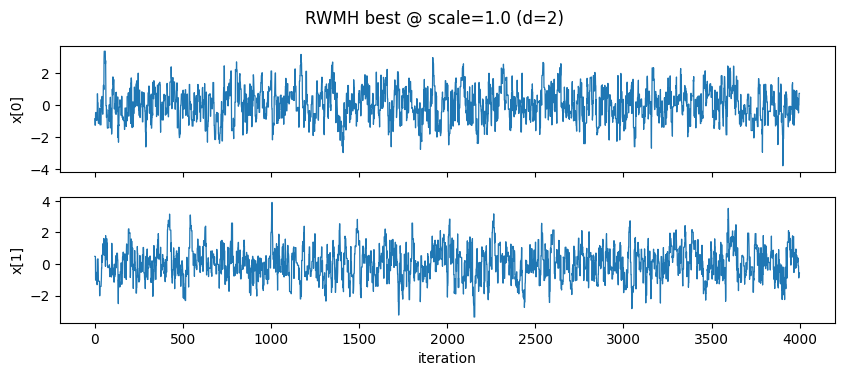

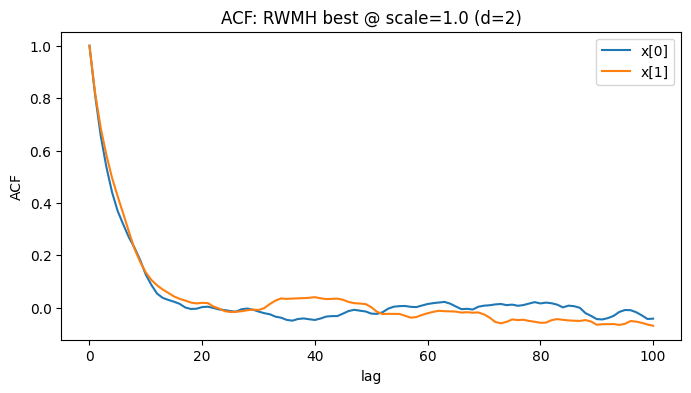

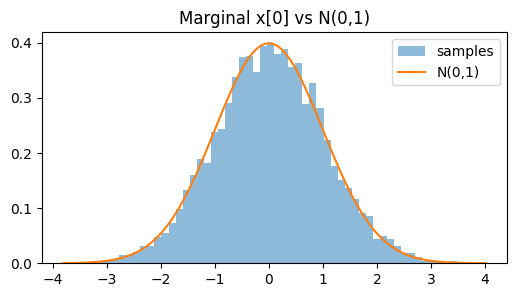

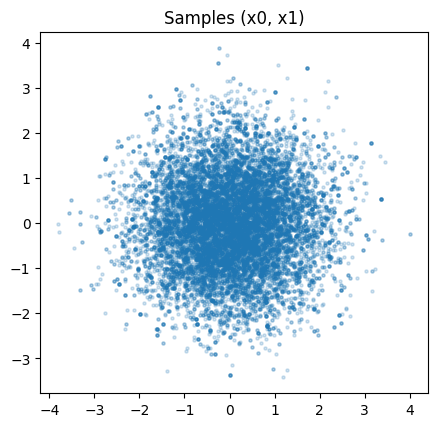

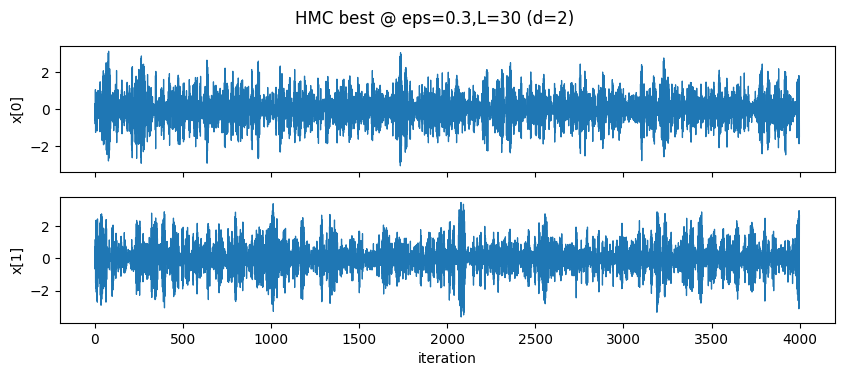

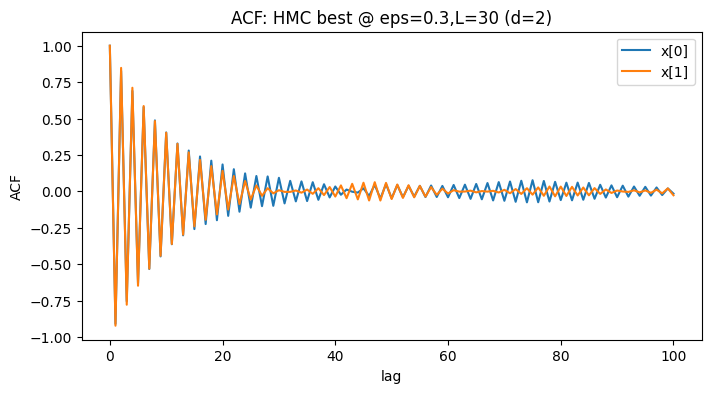

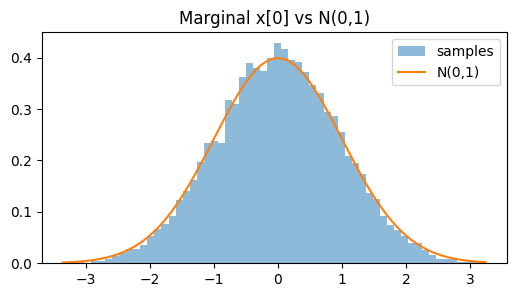

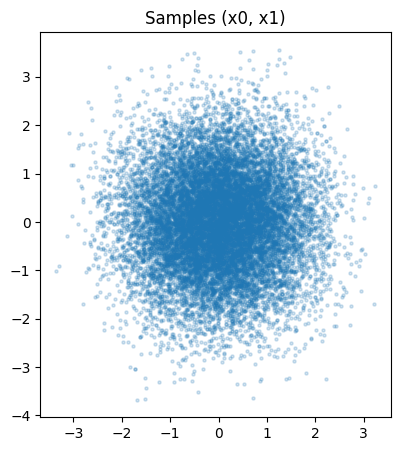

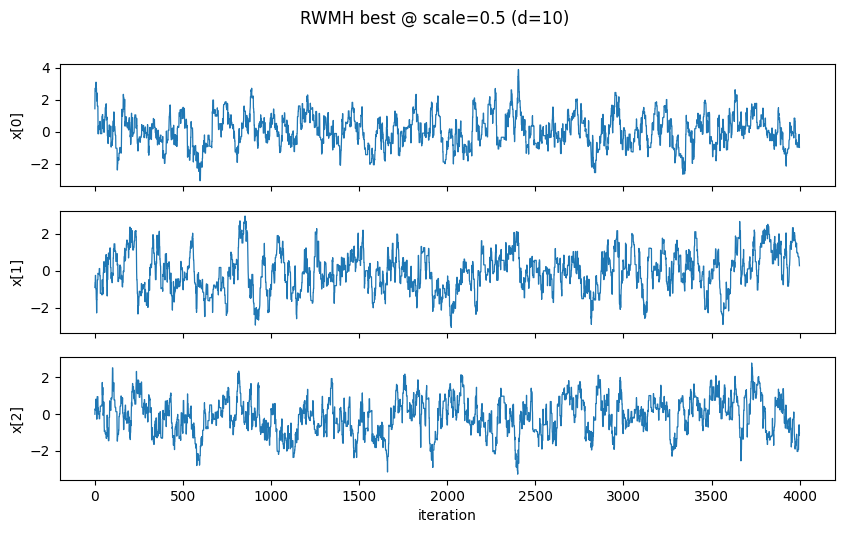

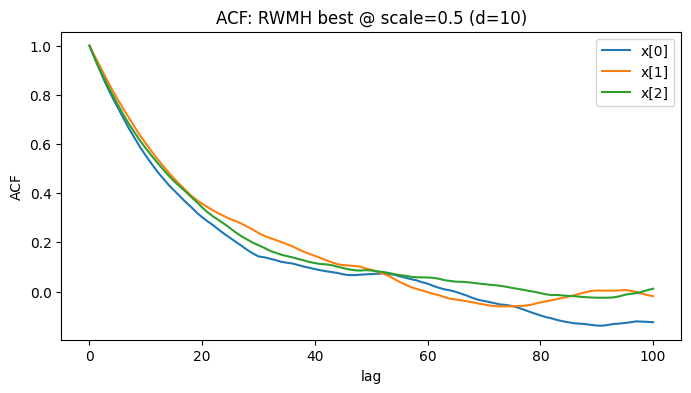

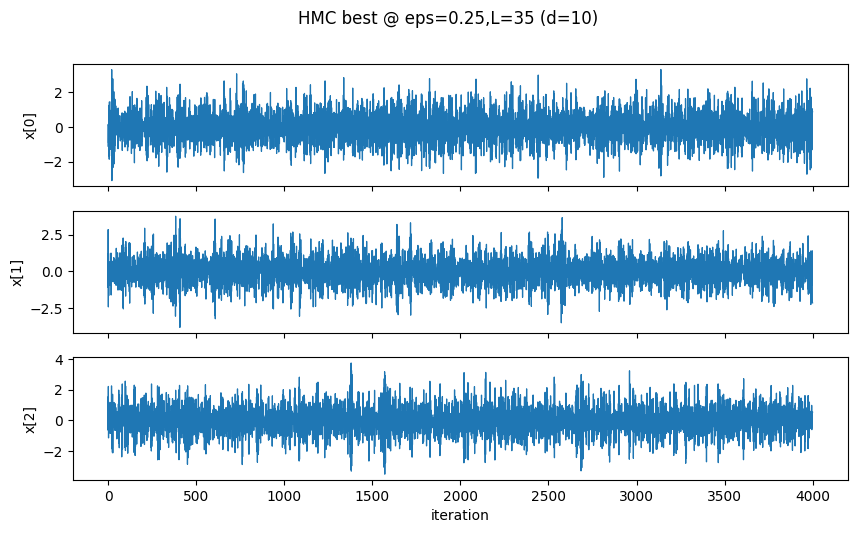

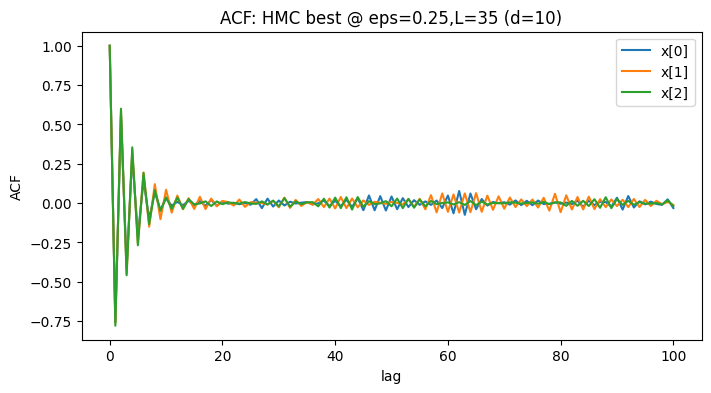

In [116]:
def show_plots_for_best(best_row: Optional[Dict]):
    if not best_row:
        print("No valid best row (R-hat gate failed).")
        return
    d = best_row["d"]
    diag = best_row["diag"]
    samples = diag["samples"]
    plot_traces(samples, dims=min(3, d), chain=0,
                title=f"{best_row['method']} best @ {best_row['hyper']} (d={d})")
    plot_acf(samples, max_lag=100, dims=min(3, d), chain=0,
             title=f"ACF: {best_row['method']} best @ {best_row['hyper']} (d={d})")
    if d == 2:
        plot_marginals_vs_true(samples)


show_plots_for_best(best_rwm_2)
show_plots_for_best(best_hmc_2)
show_plots_for_best(best_rwm_10)
show_plots_for_best(best_hmc_10)



In [78]:
dims = [2, 5, 10, 20, 50]

# Theory-scaled grids:
# RWMH: sigma = c_rwm / sqrt(d)
c_rwm_grid = [1.6, 1.9, 2.2, 2.38, 2.6, 2.8]

# HMC: epsilon = c_hmc / d**0.25
c_hmc_grid = [0.15, 0.20, 0.25, 0.30]

# Optional: fix trajectory length tau = L * eps to compare apples-to-apples
tau_grid = [1.0, 2.0]     # seconds of "Hamiltonian time" (dimensionless)
L_grid   = [10, 20, 40]   # we’ll choose L nearest to tau/eps per (d, c_hmc, tau)


In [ ]:
def run_scaled_sweeps(dims, key, n_chains=4, burn_in=1000, num_samples=4000):
    per_d_best = {"RWMH": {}, "HMC": {}}
    per_d_rows = []

    for d in dims:
        rwm_scales = [float(c) / float(np.sqrt(d)) for c in c_rwm_grid]
        df_r, best_rwm, _ = run_grid_for_d(
            d,
            key,
            n_chains=n_chains,
            burn_in_rwm=burn_in,
            num_samples_rwm=num_samples,
            burn_in_hmc=burn_in,
            num_samples_hmc=num_samples,
            rwm_scales=rwm_scales,
            hmc_eps=(0.05,),
            hmc_L=(10,),
        )
        per_d_rows.append(df_r[df_r["method"] == "RWMH"])
        per_d_best["RWMH"][d] = best_rwm

        rows_hmc = []
        best_hmc = None
        best_score = (-np.inf,)

        for c in c_hmc_grid:
            eps = float(c) / float(d**0.25)
            for tau in tau_grid:
                L_choices = sorted(set([max(1, int(round(tau / eps)))]) | set(L_grid))
                for L in L_choices:
                    key, sub = random.split(key)
                    t0 = time.perf_counter()
                    out = hmc_run(
                        sub,
                        standard_normal_log_prob,
                        jnp.zeros((n_chains, d), dtype=jnp.float32),
                        eps,
                        L,
                        num_samples,
                        burn_in=burn_in,
                    )
                    seconds = time.perf_counter() - t0
                    samples, lps, acc_rate, state = unpack_run_output(out, num_samples)
                    diag = summarize_run(samples, acc_rate, seconds)
                    row = dict(
                        method="HMC",
                        d=d,
                        hyper=f"eps={eps:.4f},L={L},tau~{L*eps:.2f}",
                        accept_mean=float(diag["accept_rate"].mean()),
                        rhat_max=float(diag["rhat"].max()),
                        ess_mean=float(diag["ess"].mean()),
                        ess_sec_mean=float(diag["ess_sec"].mean()),
                        mcse_mean_max=float(diag["mcse"].max()),
                        aux=dict(eps=eps, L=L, c_hmc=c, tau=L * eps),
                        diag=diag,
                    )
                    rows_hmc.append(row)
                    if row["rhat_max"] <= 1.01:
                        score = (row["ess_sec_mean"], -abs(row["accept_mean"] - 0.7), -row["mcse_mean_max"])
                        if score > best_score:
                            best_score = score
                            best_hmc = row

        per_d_rows.append(pd.DataFrame(rows_hmc))
        per_d_best["HMC"][d] = best_hmc

    return per_d_rows, per_d_best

rows_list, bests = run_scaled_sweeps(dims, random.PRNGKey(0))
display(pd.concat(rows_list, ignore_index=True).style.format(precision=4))


In [ ]:
# Collect scaled-opt values
rwm_x, rwm_y = [], []
hmc_x, hmc_y = [], []

for d in dims:
    b_r = bests["RWMH"].get(d)
    if b_r:
        sigma_opt = b_r["aux"]["scale"]
        rwm_x.append(d); rwm_y.append(np.sqrt(d)*sigma_opt)
    b_h = bests["HMC"].get(d)
    if b_h:
        eps_opt = b_h["aux"]["eps"]
        hmc_x.append(d); hmc_y.append((d**0.25)*eps_opt)

fig, ax = plt.subplots(1,1, figsize=(5.2,3.4))
ax.plot(rwm_x, rwm_y, marker="o")
ax.set_xlabel("dimension d"); ax.set_ylabel(r"$\sqrt{d}\,\sigma_{\text{opt}}$")
ax.axhline(2.38, ls="--", lw=1)  # theory line
ax.set_title("RWMH optimal scaling check")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5.2,3.4))
ax.plot(hmc_x, hmc_y, marker="o")
ax.set_xlabel("dimension d"); ax.set_ylabel(r"$d^{1/4}\,\epsilon_{\text{opt}}$")
ax.set_title("HMC optimal scaling check")
plt.show()
